# Разработка прогнозной модели для предсказания оттока клиентов интернет-магазина «В один клик»

В данном проекте обрабатывается запрос интернет-магазина «В один клик», который продаёт товары различных категорий. Стоит задача  на основе данных о покупателях разработать решение, которое позволит выявить снизившуюся активность и персонализировать предложения постоянным клиентам, чтобы эффективнее удерживать их.

Для решения поставленной задачи строится предсказательная модель, анализируются её результаты и интерпретируется влияние предикторов на целевую переменную. Затем на основании полученных данных выявляется и анализируется одна из прибыльных категорий покупателей с разработкой возможных предложений для удержания.

# Оглавление:
---------------------------

1. [Загрузка библиотек и исходных данных](#1)
2. [Предобработка данных](#2)
3. [Исследовательский анализ данных](#3)
4. [Объединение таблиц](#4)
5. [Корреляционный анализ](#5)
6. [Создание пайплайнов с подготовкой данных и обучением моделей](#6)
7. [Анализ важности признаков](#7)
8. [Сегментация покупателей](#8)
9. [Общий вывод](#8)

<a name="1"></a>

## Загрузка библиотек и исходных данных 

Установка пакета:

In [1]:
!pip install shap -q
!pip install scikit-learn --upgrade -q
!pip install ipywidgets -q

Загрузка библиотек:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap as shap
from sklearn.feature_selection import SelectKBest
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, fbeta_score, make_scorer, precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import pickle

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

Загрузим данные и посмотрим на общую информацию:

In [3]:
market = pd.read_csv('datasets/market_file.csv')
market_money = pd.read_csv('datasets/market_money.csv')
market_time = pd.read_csv('datasets/market_time.csv')
money = pd.read_csv('datasets/money.csv', sep=';', decimal=',')
market.info()
display(market.head())
market_money.info()
display(market_money.head())
market_time.info()
display(market_time.head())
money.info()
display(money.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<a name="2"></a>

##  Предобработка данных 

Проверим уникальные значения в нечисловых столбцах набора данных *market* на корректность, исправив неявный дубликат и опечатку. Дополнительно убедимся в отсутствии пропущенных значений и дубликатов:

In [4]:
for name in market.select_dtypes(include=[object]).columns:
    print(name, market[name].unique())
market['Тип сервиса'].replace({'стандартт': 'стандарт'}, inplace=True)
market['Популярная_категория'].replace({'Косметика и аксесуары': 'Косметика и аксессуары'}, inplace=True)
for name in market.select_dtypes(include=[object]).columns:
    print(name, market[name].unique())
print(market.isna().sum().sum())
print(market.duplicated().sum())

Покупательская активность ['Снизилась' 'Прежний уровень']
Тип сервиса ['премиум' 'стандартт' 'стандарт']
Разрешить сообщать ['да' 'нет']
Популярная_категория ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
Покупательская активность ['Снизилась' 'Прежний уровень']
Тип сервиса ['премиум' 'стандарт']
Разрешить сообщать ['да' 'нет']
Популярная_категория ['Товары для детей' 'Домашний текстиль' 'Косметика и аксессуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
0
0


Проведём аналогичную проверку для оставшихся датасетов и исправим опечатку:

In [5]:
for name in market_money.select_dtypes(include=[object]).columns:
    print(name, market_money[name].unique())
print(market_money['Период'].value_counts())
print(market_money.isna().sum().sum())
print(market_money.duplicated().sum())
for name in market_time.select_dtypes(include=[object]).columns:
    print(name, market_time[name].unique())
market_time['Период'].replace({'предыдцщий_месяц': 'предыдущий_месяц'}, inplace=True)
print(market_time.isna().sum().sum())
print(market_time.duplicated().sum())

Период ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
Период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64
0
0
Период ['текущий_месяц' 'предыдцщий_месяц']
0
0


По итогам предобработки можно отметить, что в данных почти не было ошибок и датасеты сохранились в полном объёме.

<a name="3"></a>

## Исследовательский анализ данных 

Проведём исследовательский анализ данных с разделением покупателей на снизивших и сохранивших активность. Из графиков следует, что все интервальные переменные, кроме доли акционных покупок, имеют распределение, близкое к нормальному. Категориальные переменные в основном бинарны, за исключением переменной *Популярная категория*, имеющей 6 значений с долей от 25% до 11%. Отдельно отметим, что более трети (38,3%) покупателей снизили активность.  
Можно отметить, что количество страниц за визит и маркетинговая активность для снизивших покупательскую активность чуть меньше, а почти все покупатели с большой долей акционных покупок и количеством неоплаченных товаров снижают свою активность. Категориальные переменные распределены примерно равным образом вне зависимости от активности.

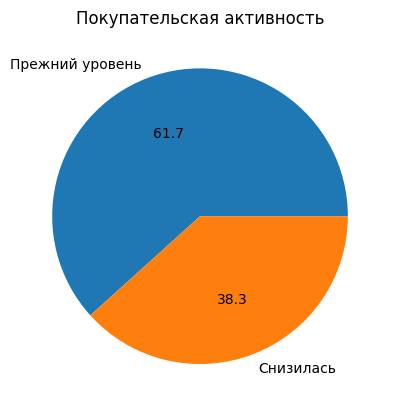

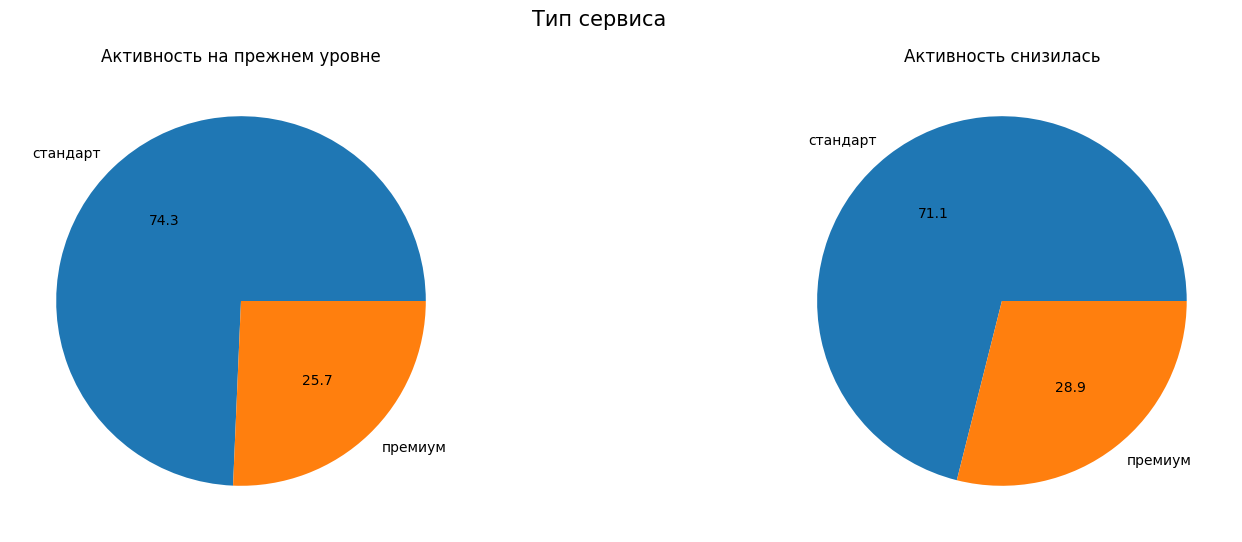

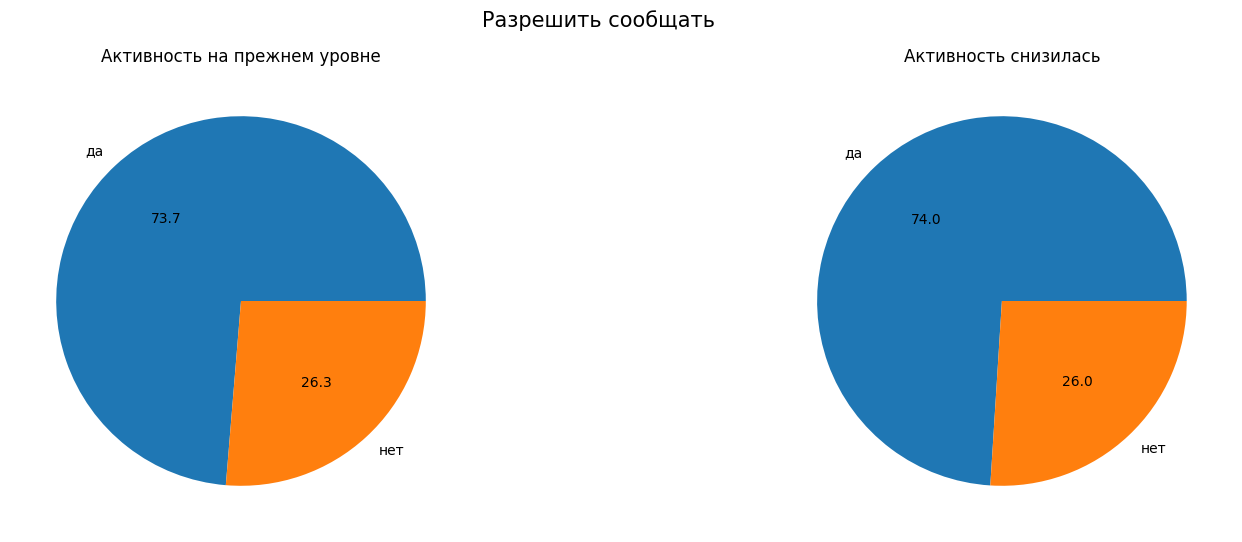

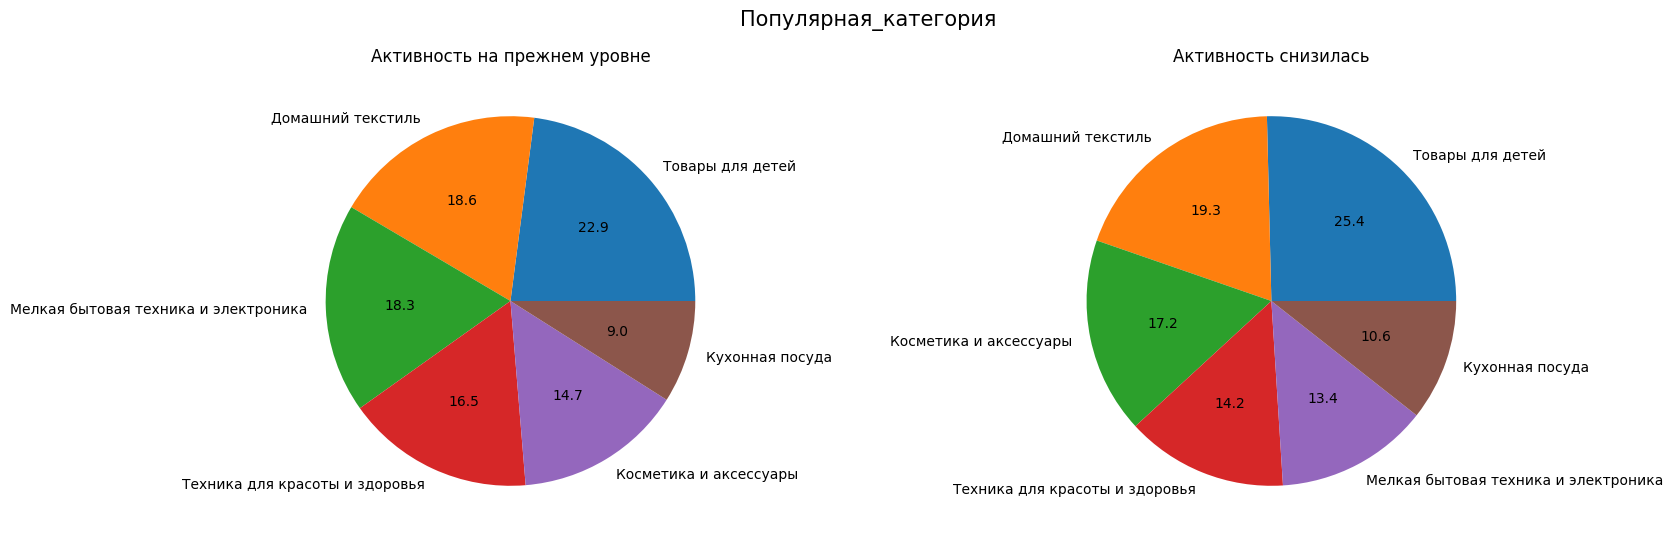

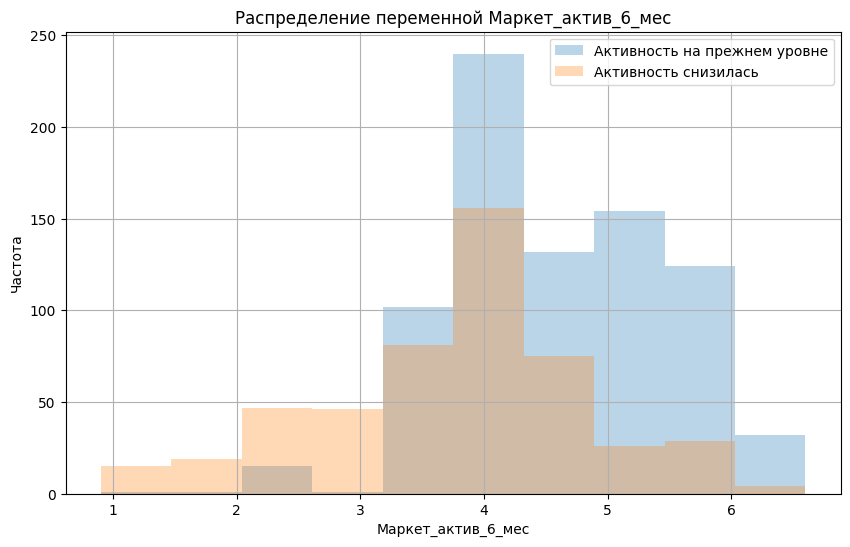

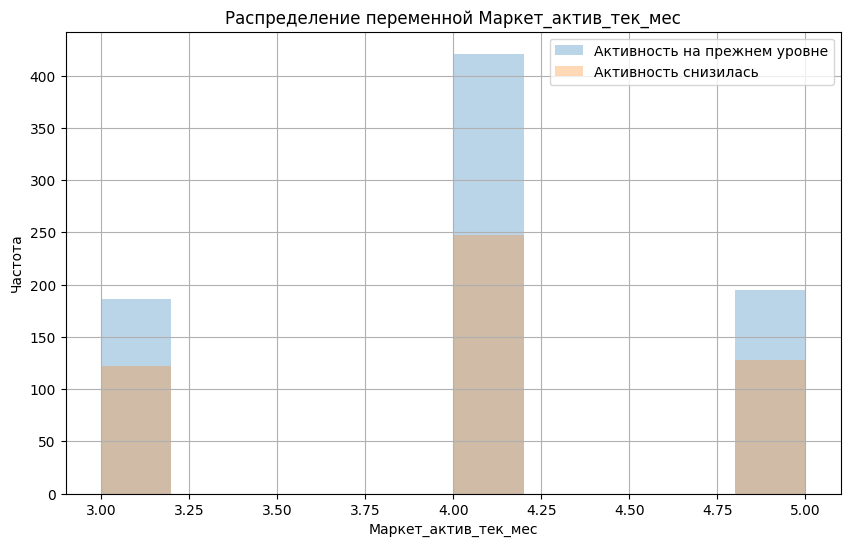

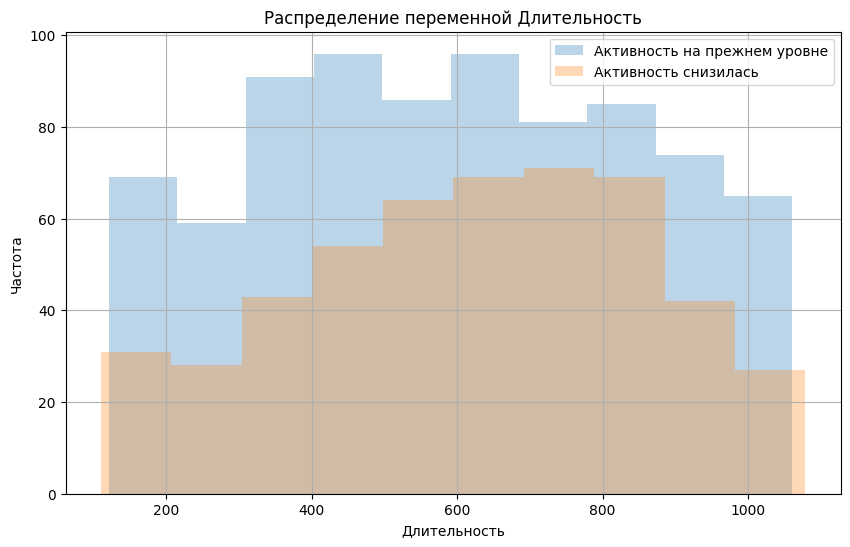

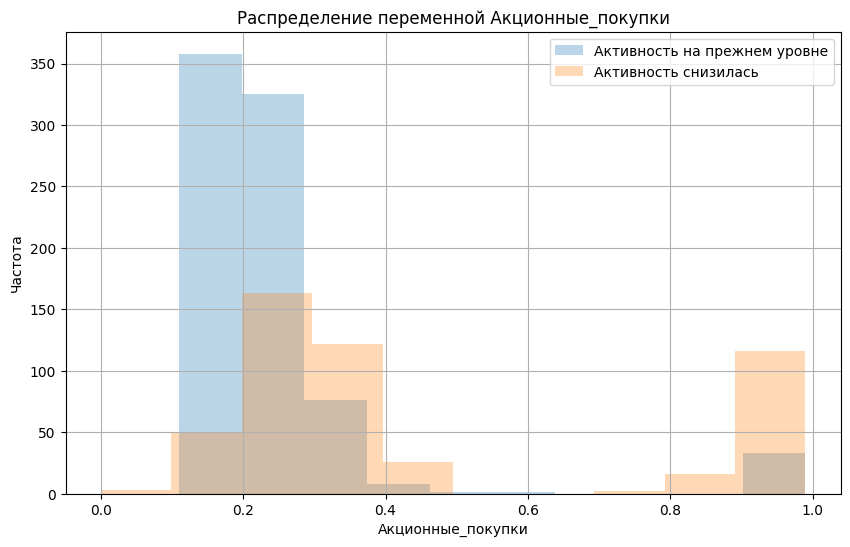

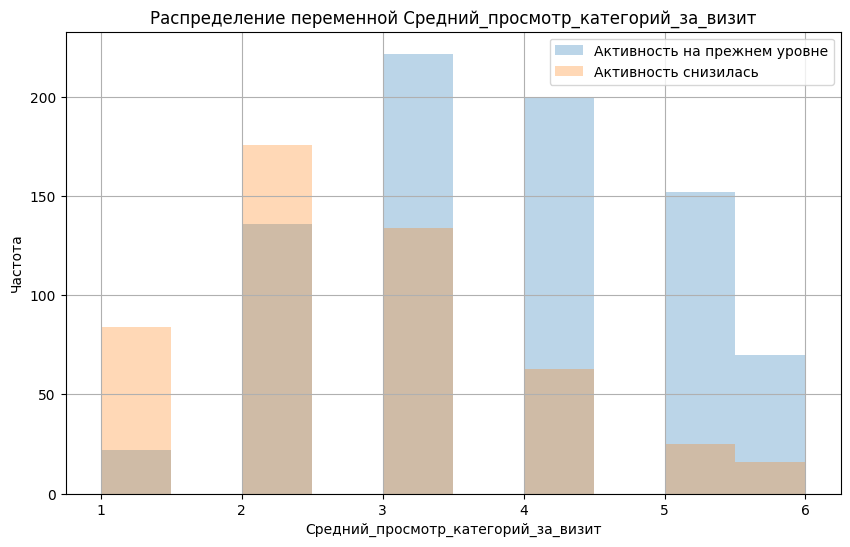

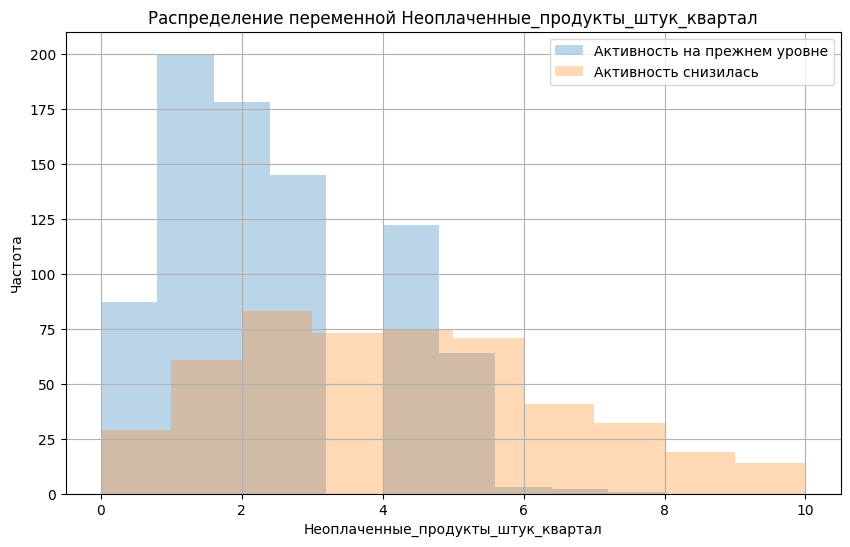

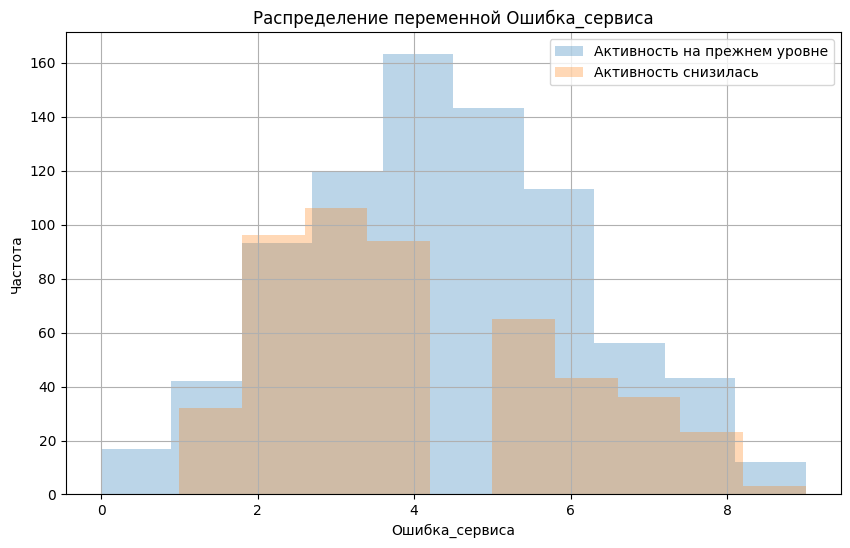

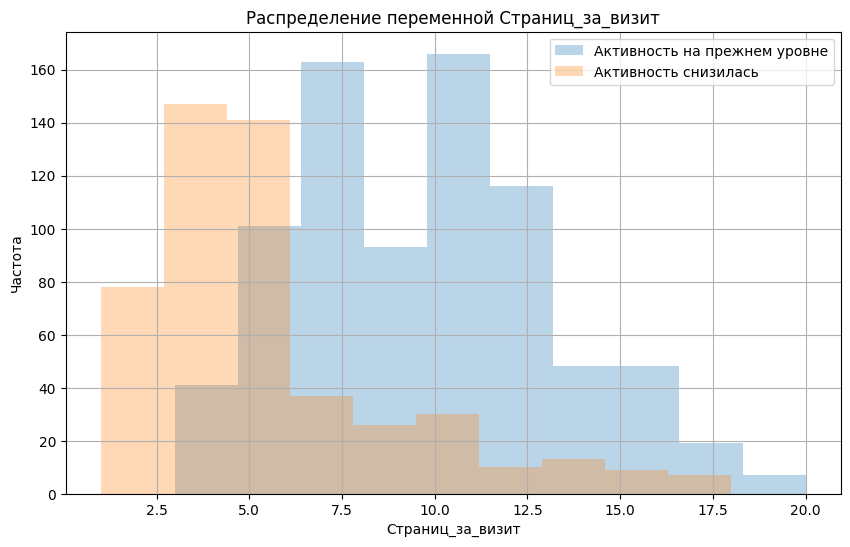

In [6]:
def plot_num(df, name, hist_only=False):
    df[name].hist(bins=10)
    plt.title(f'Распределение переменной {name}')
    plt.xlabel(name)
    plt.ylabel('Частота')
    plt.show()
    if hist_only:
        return
    df[name].plot.box()
    plt.title(f'Ящик с усами для переменной {name}')
    plt.show()

    
market.set_index('id', inplace=True)
market0 = market[market['Покупательская активность']!='Снизилась']
market1= market[market['Покупательская активность']=='Снизилась']
market['Покупательская активность'].value_counts().plot(kind='pie', autopct='%.1f')
plt.title('Покупательская активность')
plt.ylabel('')
plt.show()
for name in market.drop('Покупательская активность', axis=1).select_dtypes(include=[object]).columns: 
    fig, axes = plt.subplots(1,2,figsize=(18,6))
    plt.title(name)
    market0[name].value_counts().plot(kind='pie', autopct='%.1f', ax=axes[0])
    axes[0].set_title('Активность на прежнем уровне')
    axes[0].set_ylabel('')
    
    market[name].value_counts().plot(kind='pie', autopct='%.1f', ax=axes[1])
    axes[1].set_title('Активность снизилась')
    axes[1].set_ylabel('')
    fig.suptitle(name, fontsize=15)
    plt.show()
    
for name in market.select_dtypes(include=[np.number]).columns:   
    plt.figure(figsize=(10,6))
    market0[name].hist(bins=10, alpha=0.3)
    market1[name].hist(bins=10, alpha=0.3)
    plt.title(f'Распределение переменной {name}')
    plt.xlabel(name)
    plt.ylabel('Частота')
    plt.legend(['Активность на прежнем уровне', 'Активность снизилась'])
    plt.show()


В оставшихся наборах данных распределения имеют нормальный вид. Одно явно аномальное значение переменной *Выручка* за текущий месяц было удалено. Распределения различаются в зависимости от активности только для количества проведённых минут на сайте - у снизивших активность оно явно меньше:

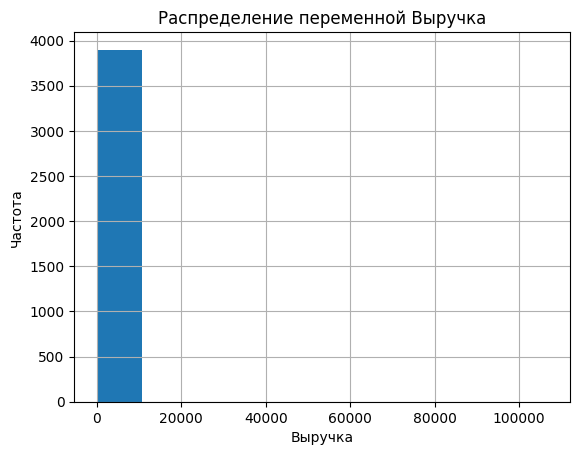

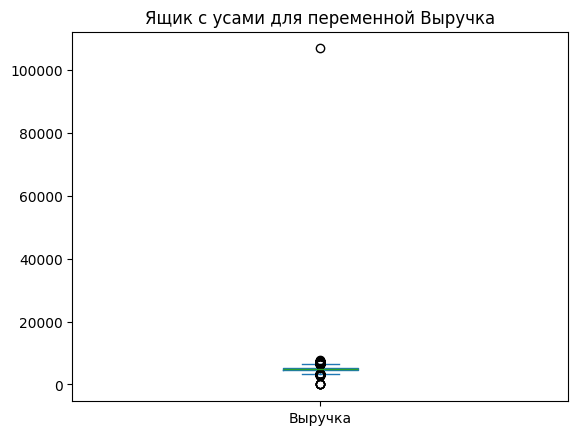

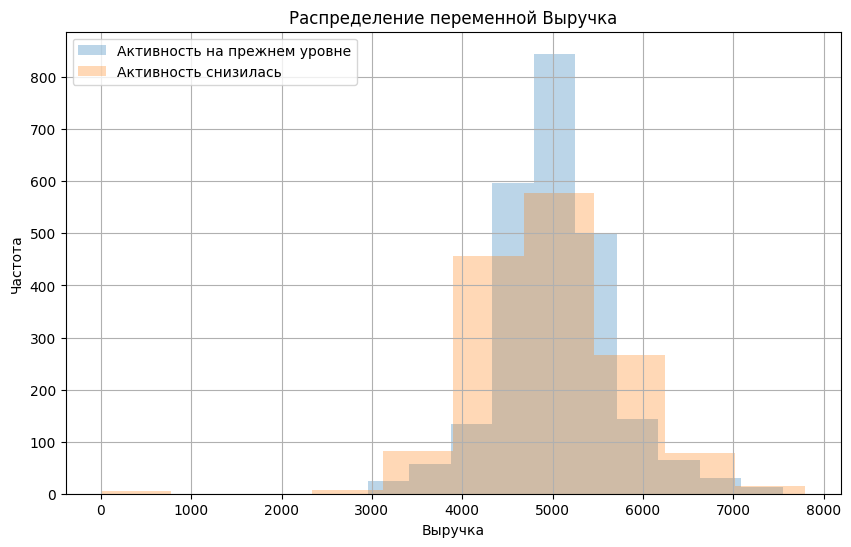

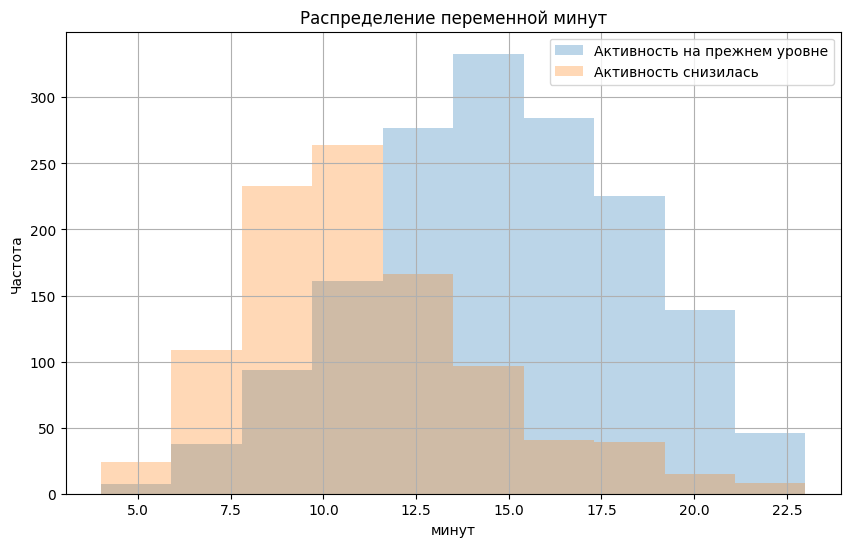

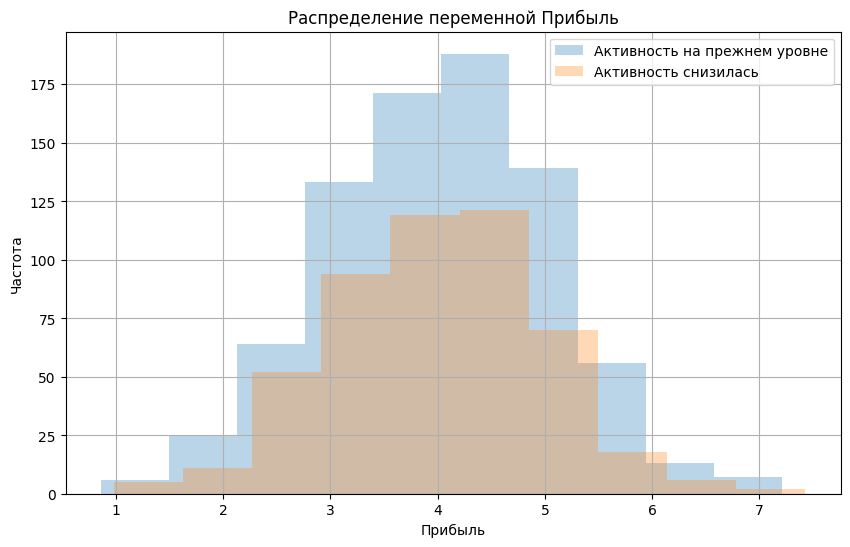

In [7]:
market_money.set_index('id', inplace=True)
market_time.set_index('id', inplace=True)
money.set_index('id', inplace=True)

plot_num(market_money, 'Выручка')
a = market_money[market_money['Выручка']>=10000].index[0]
# market_money.loc[(market_money.index==a)&(market_money['Период']=='текущий_месяц'), 'Выручка'] = market_money.loc[(market_money.index==a)&(market_money['Период']=='предыдущий_месяц'), 'Выручка']
market_money.drop(a, inplace=True)

plt.figure(figsize=(10,6))
market_money.loc[market_money.index.isin(market0.index), 'Выручка'].hist(bins=10, alpha=0.3)
market_money.loc[market_money.index.isin(market1.index), 'Выручка'].hist(bins=10, alpha=0.3)
plt.title('Распределение переменной Выручка')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.legend(['Активность на прежнем уровне', 'Активность снизилась'])
plt.show()

plt.figure(figsize=(10,6))
market_time.loc[market_time.index.isin(market0.index), 'минут'].hist(bins=10, alpha=0.3)
market_time.loc[market_time.index.isin(market1.index), 'минут'].hist(bins=10, alpha=0.3)
plt.title('Распределение переменной минут')
plt.xlabel('минут')
plt.ylabel('Частота')
plt.legend(['Активность на прежнем уровне', 'Активность снизилась'])
plt.show()

plt.figure(figsize=(10,6))
money.loc[money.index.isin(market0.index), 'Прибыль'].hist(bins=10, alpha=0.3)
money.loc[money.index.isin(market1.index), 'Прибыль'].hist(bins=10, alpha=0.3)
plt.title('Распределение переменной Прибыль')
plt.xlabel('Прибыль')
plt.ylabel('Частота')
plt.legend(['Активность на прежнем уровне', 'Активность снизилась'])
plt.show()


Покупателей с покупательской активностью не менее трёх месяцев отберём на следующей стадии, после объединения таблиц.

<a name="4"></a>

## Объединение таблиц 

Объединим таблицы *market_file*, *market_money* и *market_time*. Выделим данные о выручке и времени на сайте в отдельные столбцы для каждого месяца и отберём по выручке покупателей, активных в период помледних 3 месяцев. Итоговое количество покупателей в датасете равно 1296: 

In [8]:
def split_cols(df, col1, col2):
    new_names = [col2 + '_' + s for s in df[col1].unique()]
    df[new_names] = [[row[col2] if name == row[col1] else 0 for name in df[col1].unique()] 
                           for (_, row) in df.iterrows()]
    df.drop([col1, col2], axis=1, inplace=True)
    return df.groupby(df.index).max()


market = (market.join(split_cols(market_money, 'Период', 'Выручка'), how='inner')
          .join(split_cols(market_time, 'Период', 'минут'), how='inner'))
market = market[market['Выручка_препредыдущий_месяц']*market['Выручка_текущий_месяц']*market['Выручка_предыдущий_месяц']>0]
market.info()
market.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1296 non-null   object 
 1   Тип сервиса                          1296 non-null   object 
 2   Разрешить сообщать                   1296 non-null   object 
 3   Маркет_актив_6_мес                   1296 non-null   float64
 4   Маркет_актив_тек_мес                 1296 non-null   int64  
 5   Длительность                         1296 non-null   int64  
 6   Акционные_покупки                    1296 non-null   float64
 7   Популярная_категория                 1296 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  Ошибка_сервиса                       1296 non-null   int64  
 11  Страниц_за_визит            

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Выручка_предыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,4971.6,5216.0,10,12
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5058.4,5457.5,13,8
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6610.4,6158.0,13,11
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5872.5,5807.5,11,8
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,5388.5,4738.5,10,10


<a name="5"></a>

## Корреляционный анализ 

Проведём корреляционный анализ. Сильная связь (0,88) присутствует между столбцами *Выручка_текущий_месяц* и *Выручка_предыдущий_месяц*:

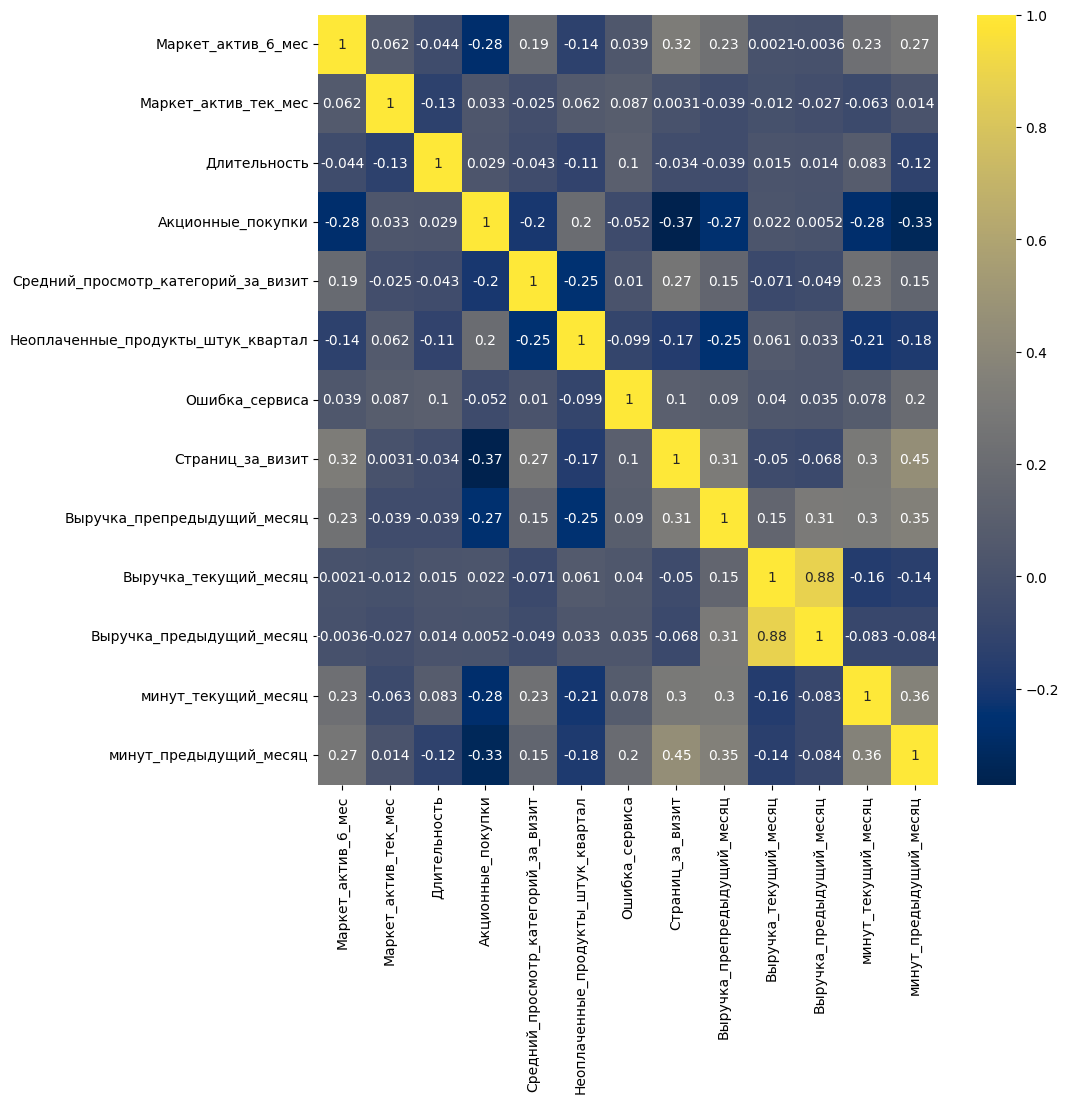

In [9]:
plt.figure(figsize=(10, 10))
sns.heatmap(market.select_dtypes('number').corr(method='spearman'), annot=True, cmap='cividis')
plt.show()

Принимая за порог уровень коэффициента корреляции 0,9, можно сказать, что в наборе данных нет мультиколлинеарности и удаление столбцов нет требуется.

<a name="6"></a>

## Создание пайплайнов с подготовкой данных и обучением моделей 

Для начала закодируем зависимую переменную и проверим, какой класс считается положительным:

In [10]:
le = LabelEncoder()
print(market['Покупательская активность'])
market['Покупательская активность'] = le.fit_transform(market['Покупательская активность'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

id
215349          Снизилась
215350          Снизилась
215351          Снизилась
215352          Снизилась
215353          Снизилась
               ...       
216643    Прежний уровень
216644    Прежний уровень
216645    Прежний уровень
216646    Прежний уровень
216647    Прежний уровень
Name: Покупательская активность, Length: 1296, dtype: object


{'Прежний уровень': np.int64(0), 'Снизилась': np.int64(1)}

В рамках конвейера произведём подготовку данных. Для категориальных столбцов будет происходить кодирование, а для интервальных - масштабирование и полиномизация. Дополнительно произведём отбор признаков и затем обучим на данных модель. В рамках поиска по решётке перебираются различные гиперпараметры для 4 моделей (метод опорных векторов, дерево, метод ближайших соседей и логистическая регрессия). Среди этих гиперпараметров присутствуют метод масштабирования, степень регуляризации модели, выбор ядра, степень полинома для полиномиального ядра, метод нахождения параметров модели для логистической регрессии, наличие или отсутствие полиномизации признаков и др.

В   рамках рассматриваемой задачи, вероятно, более важно выявлять тех покупателей, которые снизили свою активность, чтобы предложить им различные акции или как-то ещё маркетинговым образом удержать их. В связи с этим был сделан выбор в пользу метрики F1 (recall равен по важности precision).

Как видно, среди изученных наборов гиперпараметров оптимальный результат получается при использовании SVC без полиномизации с параметрами C=1, gamma=0,2, ядро: rbf, метод масштабирования: StandardScaler. Результат на тренировочной выборке при кросс-валидации: 0,843. На тестовой выборке: 0,871

In [11]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
BETA = 1
fbeta = make_scorer(fbeta_score, beta=BETA, greater_is_better=True)

X_train, X_test, y_train, y_test = train_test_split(
    market.drop(['Покупательская активность'], axis=1),
    market['Покупательская активность'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=market['Покупательская активность'])

ohe_columns = X_train.select_dtypes('object').columns
num_columns = X_train.select_dtypes('number').columns

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', sparse_output=False))
     ])

num_pipe = Pipeline(
    [('scaler', MinMaxScaler()),
     ('poly', PolynomialFeatures(degree=2, include_bias=False))
     ])

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', num_pipe, num_columns),
     ],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('selector', SelectKBest(k=30)),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 12),
        'models__min_samples_split': range(2, 12),
        'models__min_samples_leaf': range(1, 12),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, int(len(X_train) * 0.05)),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },

    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)],
        'models__C': [0.05, 0.1, 0.5, 1, 5, 10, 50],
        'models__penalty': ['l1', 'l2'],
        'models__solver': ['saga', 'liblinear'],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [1, 3, 5, 7, 10],
        'models__gamma': [0.01, 0.05, 0.1, 0.2, 0.5],
        'models__kernel': ['rbf', 'sigmoid'],
        'selector__k': [20, 30, 40],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [1, 3, 5, 7, 10],
        'models__gamma': [0.01, 0.05, 0.1, 0.2, 0.5],
        'models__kernel': ['rbf'],
        'selector': ['passthrough'],
        'preprocessor__num__poly': ['passthrough'],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    },

    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='linear', probability=True)],
        'models__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },

    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly', probability=True)],
        'models__C': [1, 5, 10, 20],
        'models__gamma': [0.1, 0.5, 1],
        'models__degree': [2, 3, 4],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly', probability=True)],
        'models__C': [0.05, 0.1, 0.5, 1],
        'models__gamma': [1, 5, 10, 20],
        'models__degree': [2, 3, 4],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
]

hyper_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=fbeta,
    verbose=3,
    n_jobs=-1,
    return_train_score=True,
)

use_prev = True
filename = 'final_model.sav'
if use_prev:
    hyper_search = pickle.load(open(filename, 'rb'))
else:
    hyper_search.fit(X_train, y_train)
    pickle.dump(hyper_search, open(filename, 'wb'))

print('Лучшая модель и её параметры:\n\n', hyper_search.best_estimator_)
print(hyper_search.best_params_)
print(f'Метрика лучшей модели на тренировочной выборке: {hyper_search.best_score_:.3f}')

y_test_pred = hyper_search.predict(X_test)
print(y_test_pred[:5])
print(y_test[:5])
print(f'Метрика F{BETA} на тестовой выборке: {fbeta_score(y_test, y_test_pred, beta=BETA):.3f}')
print(f'Метрика precision на тестовой выборке: {precision_score(y_test, y_test_pred):.3f}')
print(f'Метрика recall на тестовой выборке: {recall_score(y_test, y_test_pred):.3f}')


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  Index(['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   Stand...

Для демонстрации свойств модели и потенциального использования в случае уточнения приоритетов и метрик дополнительно выясним, какой порог является оптимальным. По итогам анализа ясно, что наилучший порог составляет 0,567, а соответствующее значение метрики равно 0,886. Метрика и значение порога не сильно меняются по сравнению с базовым вариантом, а при достижении показателя recall примерно 0,82 precision начинает резко снижаться. Значит, базовый вариант близок к оптимальному:

Лучший порог: 0.567, F1: 0.886, precision: 0.962, recall: 0.821


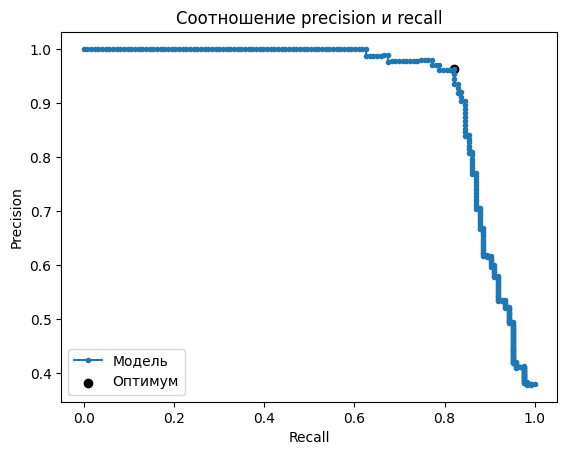

In [12]:
y_pred = hyper_search.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
f2score = ((1+BETA*BETA) * precision * recall) / (BETA*BETA*precision + recall)
ix = np.argmax(f2score)
print(f'Лучший порог: {thresholds[ix]:.3f}, F{BETA}: {f2score[ix]:.3f}, precision: {precision[ix]:.3f}, recall: {recall[ix]:.3f}')
plt.plot(recall, precision, marker='.', label='Модель')
plt.title('Cоотношение precision и recall')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Оптимум')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


<a name="7"></a>

## Анализ важности признаков 

Для начала исследуем важность признков с помощью permutation importance. Можно отметить наиболее важные признаки: доля акционных покупок, среднее количество просмотренных за визит страниц, количество проведённого на сайти времени в текущем и предыдущем месяце, маркетинговая активность за 6 месяцев (среднемесячное значение маркетинговых коммуникаций). Такие признаки, как тип сервиса (наличие премиум-сервиса), ошибка сервиса, разрешение присылать сообщения,  длительность с момента регистрации, среднее количество просмотренных за визит категорий и маркетинговая активность в текущем месяце оказываются незначимыми для модели.

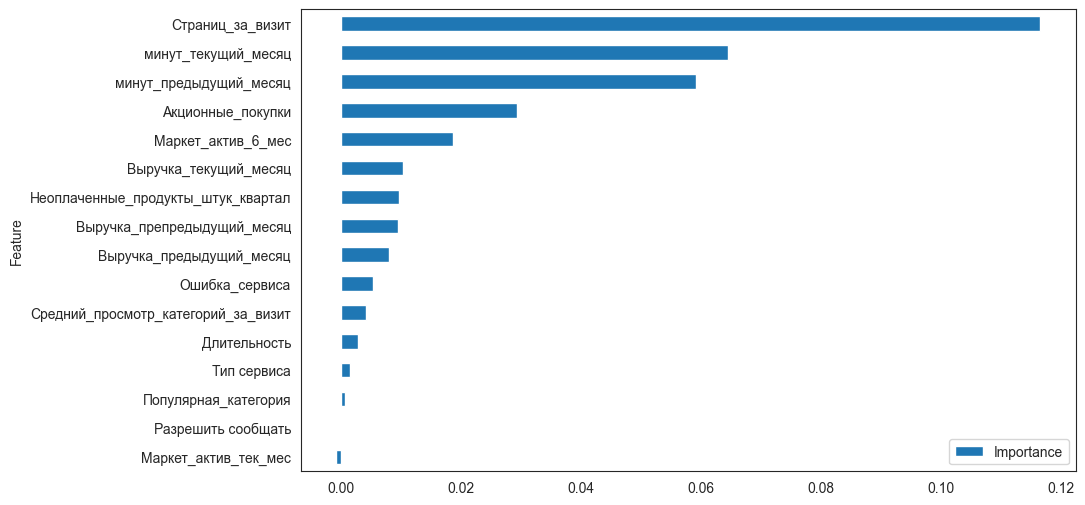

In [13]:
result = permutation_importance(hyper_search, X_test, y_test, scoring=fbeta, n_repeats=15, random_state=RANDOM_STATE)
feature_importance = pd.DataFrame({'Feature': X_test.columns, 'Importance': result['importances_mean']}).sort_values(
    'Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

Посмотрим на важность признаков и через призму SHAP-значений. Из первых восьми признаков почти все совпадают с предыдущими результатами: 
1. Среднее количество просмотренных за визит страниц  
2. Количество минут на сайте в текущем месяце  
3. Количество минут на сайте в предыдущем месяце  
4. Среднее количество просмотренных за визит категорий 
5. Выручка за препредыдущий месяц  
6. Доля акционных покупок  
7. Маркетинговая активность за 6 месяцев
8. Количество неоплаченных продуктов за квартал

Из новых сведений бросаются в глаза вышедшие на четвёртое и пятое место признаки *Средний_просмотр_категорий_за_визит* и *Выручка_препредыдущий_месяц*.

(324, 20)
['ohe__Тип сервиса_стандарт', 'ohe__Разрешить сообщать_нет', 'ohe__Популярная_категория_Косметика и аксессуары', 'ohe__Популярная_категория_Кухонная посуда', 'ohe__Популярная_категория_Мелкая бытовая техника и электроника', 'ohe__Популярная_категория_Техника для красоты и здоровья', 'ohe__Популярная_категория_Товары для детей', 'num__Маркет_актив_6_мес', 'num__Маркет_актив_тек_мес', 'num__Длительность', 'num__Акционные_покупки', 'num__Средний_просмотр_категорий_за_визит', 'num__Неоплаченные_продукты_штук_квартал', 'num__Ошибка_сервиса', 'num__Страниц_за_визит', 'num__Выручка_препредыдущий_месяц', 'num__Выручка_текущий_месяц', 'num__Выручка_предыдущий_месяц', 'num__минут_текущий_месяц', 'num__минут_предыдущий_месяц']


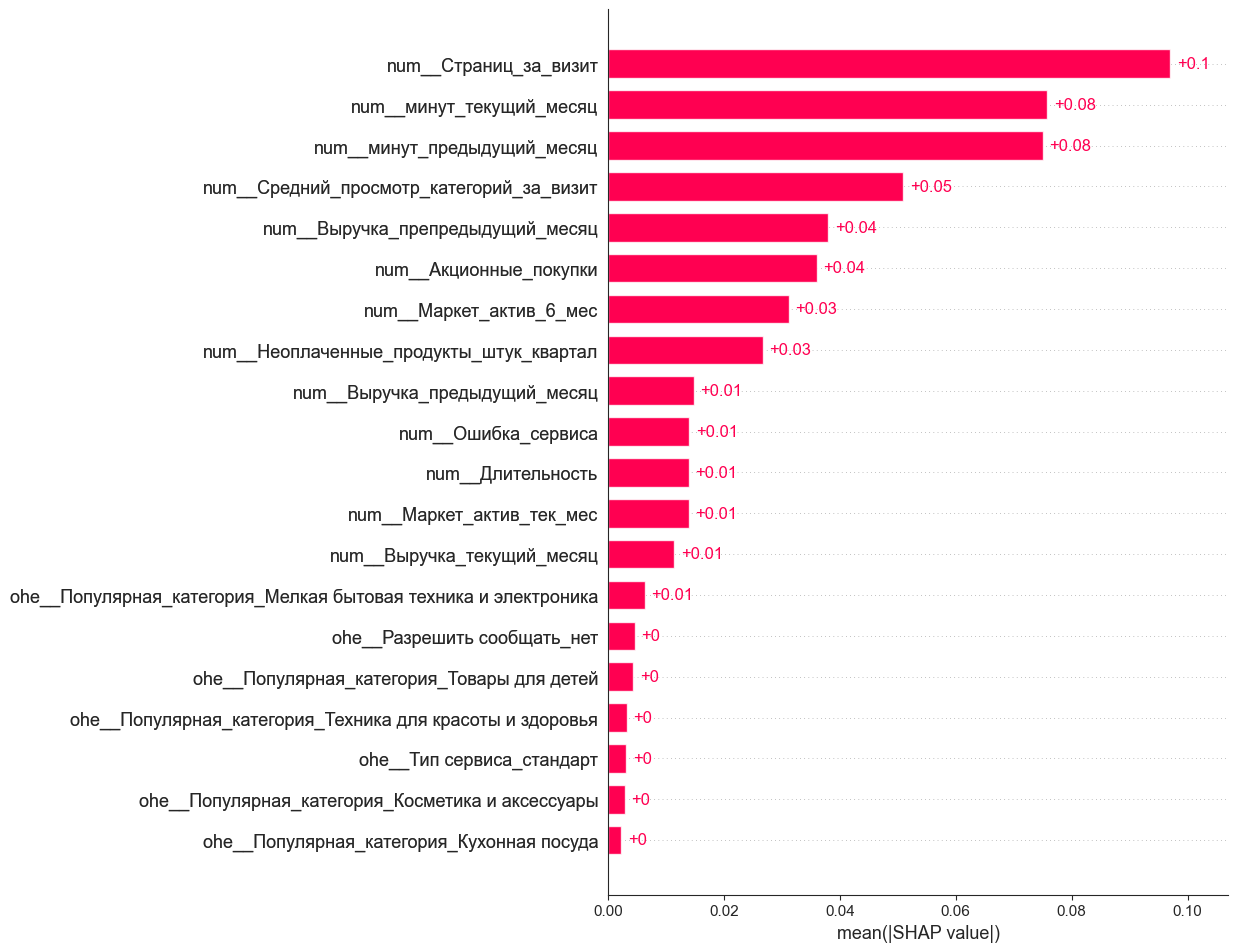

In [14]:
X_test_pre = hyper_search.best_estimator_['preprocessor'].transform(X_test)
print(X_test_pre.shape)

feature_names = [x for x in hyper_search.best_estimator_['preprocessor'].get_feature_names_out()]
print(feature_names)
explainer = shap.KernelExplainer(lambda x: hyper_search.best_estimator_['models'].predict_proba(x)[:, 1],
                                 shap.sample(X_test_pre, 20), feature_names=feature_names)

shap_ready = True
filename1 = 'shap.pkl'
if shap_ready:
    shap_values = pickle.load(open(filename1, 'rb'))
else:
    shap_values = explainer(X_test_pre)
    pickle.dump(shap_values, open(filename1, 'wb'))

shap.plots.bar(shap_values, max_display=20)
plt.show()

Проверим, в каком направлении влияют признаки. Как и следовало ожидать, чем выше активность пользователей на сайте (среднее количество просмотренных страниц и категорий, проведённых минут), тем меньше вероятность, что покупатель снизит активность. Аналогичная связь прослеживается для маркетинговой активности и выручки за препредыдущий месяц. Напротив, для покупателей с высокой долей акционных покупок вероятность снижения активности увеличивается. Возможно, это отражает тех покупателей, которые воспользовались сайтом только из-за акций и не намерены проявлять постоянную активность на нём. Это соотносится с полученным ранее распределением доли акционных покупок, в которой покупатели чётко делятся на группу с низкой долей и группу с высокой долей, с проседанием в центре. Также из графика следует, что покупатели с очень высоким количеством неоплаченных продуктов скорее всего сократят активность:

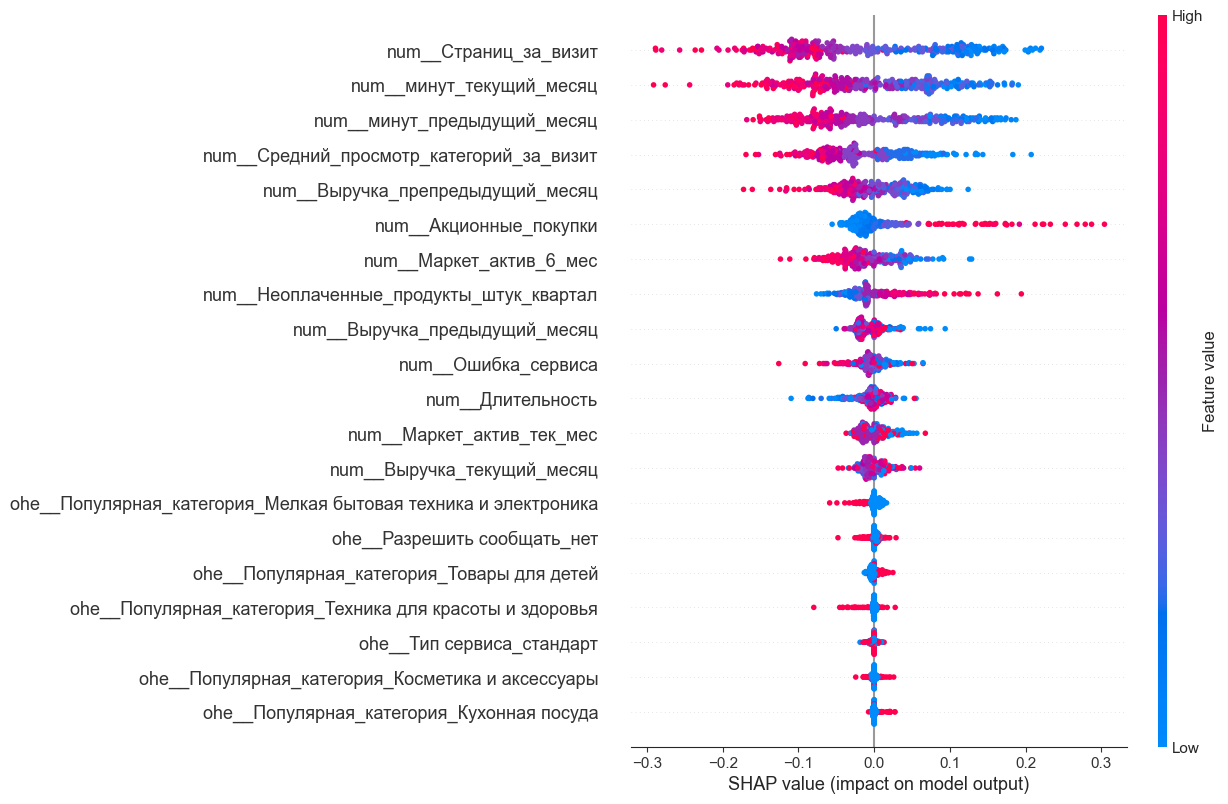

In [15]:
shap.plots.beeswarm(shap_values, max_display=20) 

Подводя итого, можно сказать, что на целевой признак более всего влияет то, как активен покупатель на сайте (просмотренные страницы и категории, проведённое время), как часто он использует акции, сколько выручки принёс в препредыдущем месяце и насколько интенсивны макркетинговые взаимодействия с ним. На основе этих данных можно выявлять покупателей в зоне риска и пытаться удержать их выгодными предложениями и прочими маркетинговыми уловками.

<a name="8"></a>

## Сегментация покупателей 

Выделим сегмент самых прибыльных покупателей, которые с высокой вероятностью снизят активность. Для этого сначала посмотрим, как в целом распределена прибыльность покупателей. На графике заметно, что распределение имеет форму нормального. Далее из 324 покупателей выделим 100 самых прибыльных и посмотрим на графике, как для них соотносятся прибыльность и вероятность снизить активность. В качестве одного из естественных порогов на графике предстаёт значение 0,6 его и выберем для фильтрации. В итоге получим 35 человек:

324


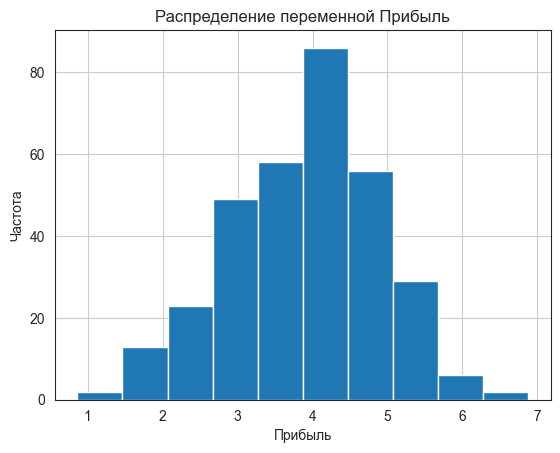

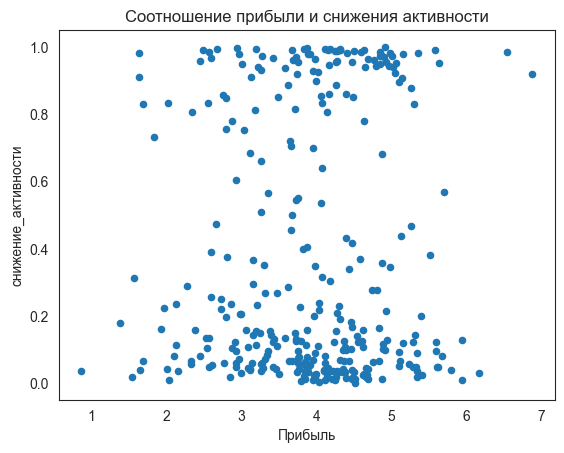

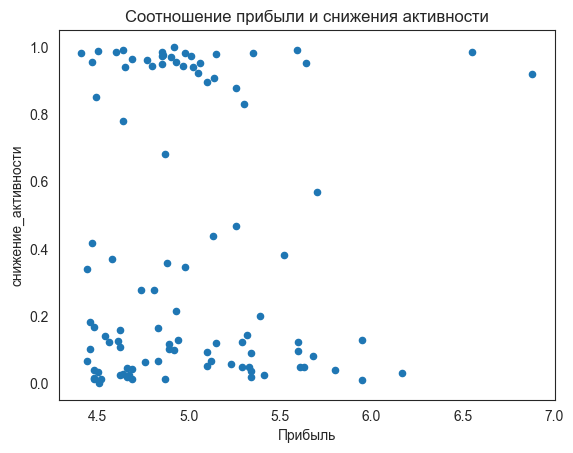

35


In [16]:
uni = X_test.join(money)
print(len(uni))
uni['снижение_активности'] = y_pred
plot_num(uni, 'Прибыль', True)

k=100
segm = uni.nlargest(k, 'Прибыль', 'all')

uni.plot(x='Прибыль', y='снижение_активности', kind='scatter')
plt.title('Соотношение прибыли и снижения активности')
plt.show()
segm.plot(x='Прибыль', y='снижение_активности', kind='scatter')
plt.title('Соотношение прибыли и снижения активности')
plt.show()

segm = segm[segm['снижение_активности']>0.6]
print(len(segm))


Исследуем выделенный сегмент чуть глубже. Для начала сравним признак маркетинговой активности за последние 6 месяцев в рамках сегмента и вне его. Видно, что с покупателями в данном сегменте взаимодействовали чуть меньше, но разница не так велика. Теперь рассмотрим, как влияет на вероятность снижения активности количество взаимодействий с клиентом. На совместном графике заметно, что при значениях маркетинговой активности больше 4 вероятность заметно снижается. На следующем этапе посмотрим, в каких категориях чаще всего совершают покупки клиенты из рассматриваемого сегмента и сравним с общим распределением. Можно отметить, что в рамках сегмента заметно выше спрос на товары для детей, косметику и аксессуары, а также кухонную посуду. Напротив, покупатели из сегмента реже выбирают бытовую и прочую технику. Наконец, рассмотрим долю давших согласие на получение дополнительных предложений. Из графика следует, что доля таких покупателей в сегменте почти не отличается.<br>
Дополнительно построена таблица изменения выручки по каждой категории за последние 3 месяца. Видно, что выручка от покупателей сегмента в категории детских товаров снизилась в прошлом месяце. В остальном выручка постепенно растёт.

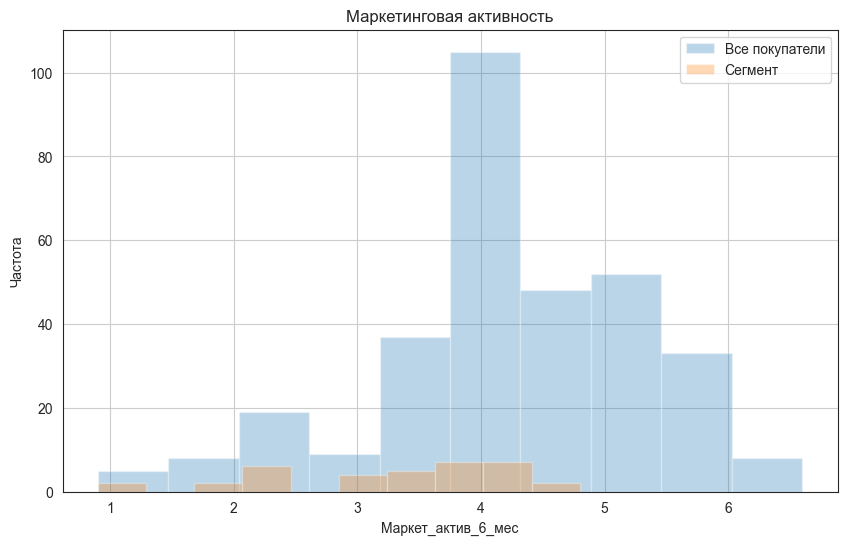

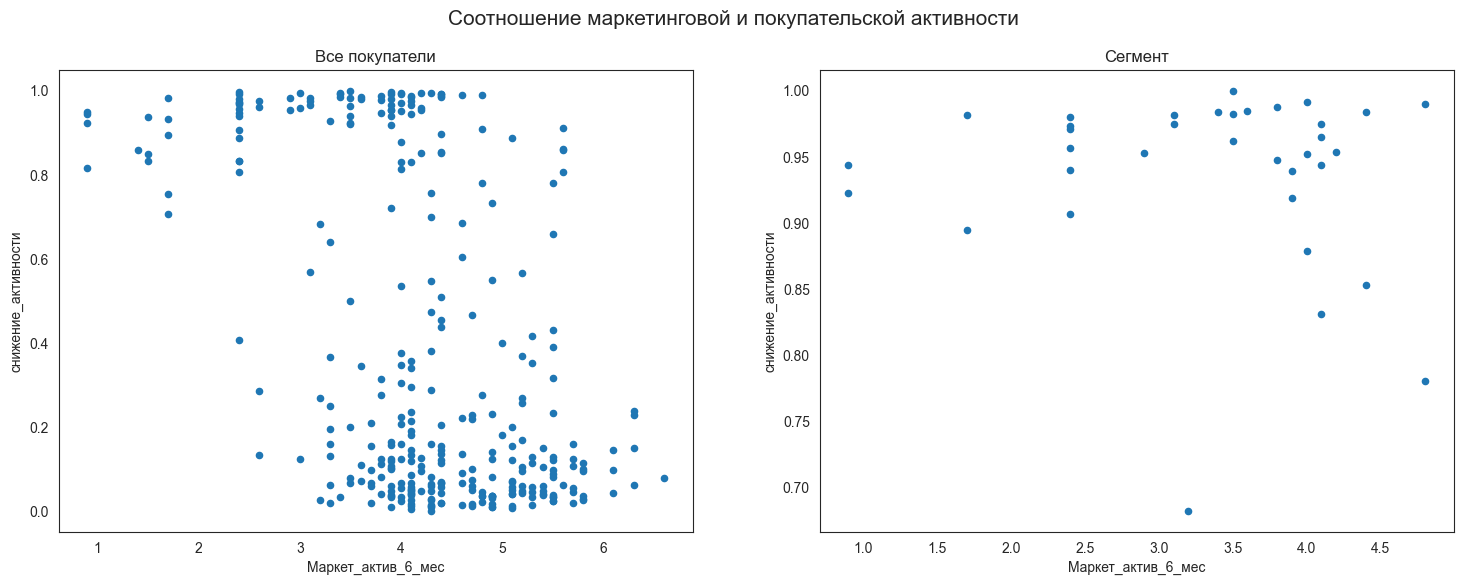

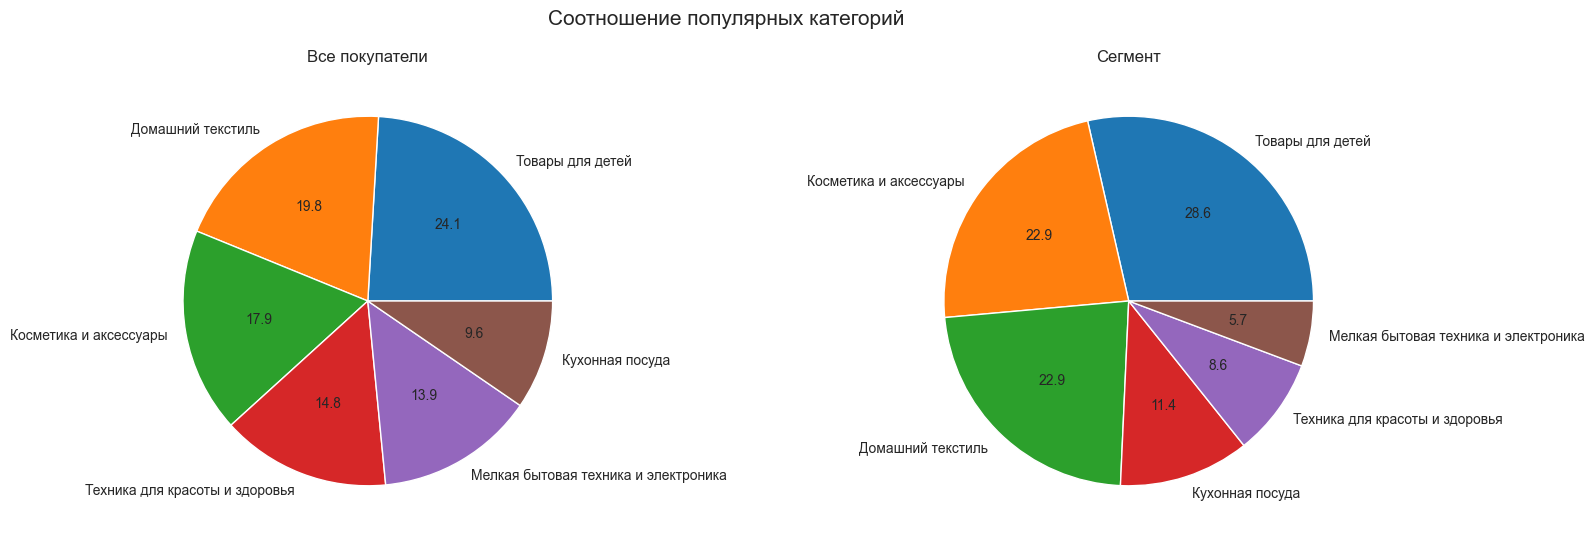

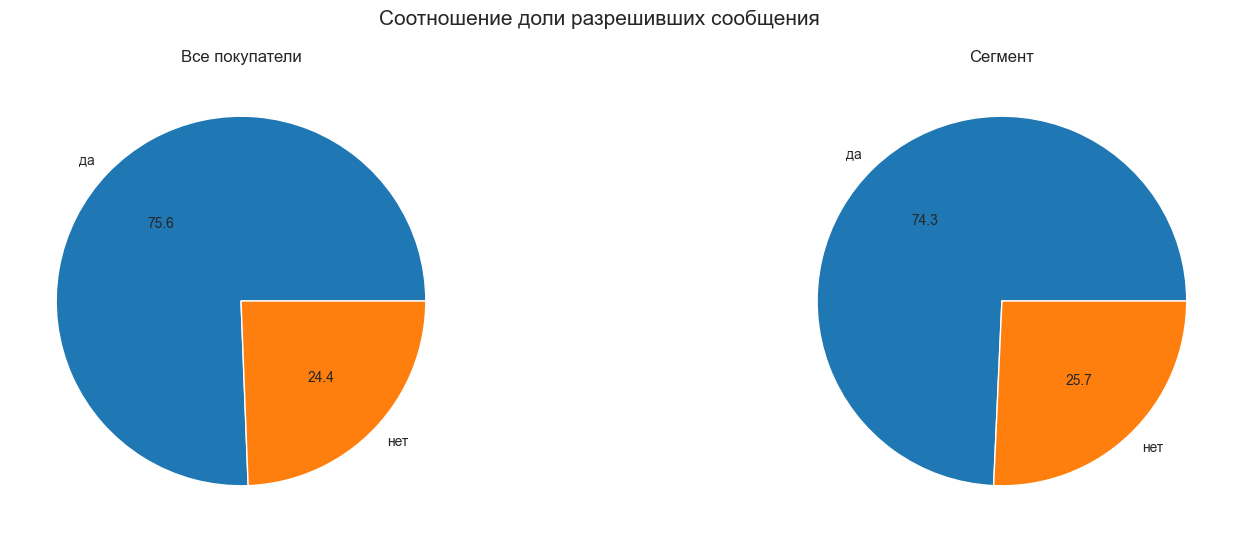

,Выручка_препредыдущий_месяц,Выручка_предыдущий_месяц,Выручка_текущий_месяц
Популярная_категория,,,
Домашний текстиль,37146.0,42127.5,44269.9
Косметика и аксессуары,37297.0,40922.5,42131.5
Кухонная посуда,18418.0,23389.0,24721.5
Мелкая бытовая техника и электроника,9547.0,11185.0,11980.6
Техника для красоты и здоровья,13866.0,12921.0,13521.6
Товары для детей,46936.0,47070.0,49316.4


In [17]:
plt.figure(figsize=(10,6))
uni['Маркет_актив_6_мес'].hist(bins=10, alpha=0.3)
segm['Маркет_актив_6_мес'].hist(bins=10, alpha=0.3)
plt.title('Маркетинговая активность')
plt.xlabel('Маркет_актив_6_мес')
plt.ylabel('Частота')
plt.legend(['Все покупатели', 'Сегмент'])
plt.show()

fig, axes = plt.subplots(1,2,figsize=(18,6))
uni.plot(x='Маркет_актив_6_мес', y='снижение_активности', kind='scatter', ax=axes[0])
segm.plot(x='Маркет_актив_6_мес', y='снижение_активности', kind='scatter', ax=axes[1])
axes[0].set_title('Все покупатели')
axes[1].set_title('Сегмент')
fig.suptitle('Соотношение маркетинговой и покупательской активности', fontsize=15)
plt.show()

fig, axes = plt.subplots(1,2,figsize=(18,6))
uni['Популярная_категория'].value_counts().plot(kind='pie', autopct='%.1f', ax=axes[0])
segm['Популярная_категория'].value_counts().plot(kind='pie', autopct='%.1f', ax=axes[1])
axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[0].set_title('Все покупатели')
axes[1].set_title('Сегмент')
fig.suptitle('Соотношение популярных категорий', fontsize=15)
plt.show()

fig, axes = plt.subplots(1,2,figsize=(18,6))
uni['Разрешить сообщать'].value_counts().plot(kind='pie', autopct='%.1f', ax=axes[0])
segm['Разрешить сообщать'].value_counts().plot(kind='pie', autopct='%.1f', ax=axes[1])
axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[0].set_title('Все покупатели')
axes[1].set_title('Сегмент')
fig.suptitle('Соотношение доли разрешивших сообщения', fontsize=15)
plt.show()

segm.groupby('Популярная_категория')[['Выручка_препредыдущий_месяц', 'Выручка_предыдущий_месяц', 'Выручка_текущий_месяц']].sum()

Итог:  
1. Клиенты с большим числом коммуникаций (более 4) реже снижали активность. При этом важно отметить, что число коммуникаций в текущем месяце не показывает связь с вероятностью снизить активность. Можно предложить увеличить количество среднемесячных долгосрочных маркетинговых коммуникаций с ними. 
2. Более интересны для рассматриваемого сегмента товары из категорий *товары для детей*, *косметика и аксессуары*, *кухонная посуда*.  Возможно введение программы лояльности с повышенными бонусами для товаров из таких категорий. 
3. На графиках заметны два покупателя, прибыль от которых заметно выше, чем от остальных, при этом их вероятность снизить активность высока. Для них возможна опция эксклюзивных предложения для клиентов, которые должны в том числе опираться на предпочитаемую категорию конкретного пользователя.
4. Разрешение на рассылку не показывает значимости. Следовательно, соответствующие рассылки не рекомендуется использовать для удержания клиентов.

<a name="9"></a>

## Общий вывод 

В ходе работы был проведён анализ данных о покупателях интернет-магазина «В один клик» с целью выявить клиентов, которые скорее всего снизят активность, и факторы, которые на это влияют. В дальнейшем полученные сведения были использованы для выявления сегмента наиболее прибыльных покупателей, рискующих снизить активность. На финальном этапе были предложены маркетинговые опции, которые могли бы эффективно удержать рассмтриваемых покупателей.  
Работа состояла из следующих этапов:
1. Загрузка данных для 1300 покупателей из 4 датасетов *market_file.csv* (данные о поведении покупателя на сайте и коммуникациях с покупателем), *market_money_csv* (выручка, которую получает магазин с покупателя), market_time.csv (время, которое покупатель провёл на сайте) и *money.csv* (среднемесячная прибыль покупателя).
2. Предобработка данных. За исключением опечаток, других ошибок не обнаружено. Набор данных сохранён в полном объёме.
3. Исследовательский анализ данных. Все интервальные переменные, кроме доли акционных покупок, имеют нормальное распределение. Было выявлено и заменено одно аномальное значение *Выручки*, соответствующий покупатель был удалён из датасета. 3 покупателя не проявили активность хотя бы в одном из 3 последних месяцев и были исключены из рассмотрения. Доля покупателей, снизивших активность: 38,3%.
4. Объединение таблиц *market_file*, *market_money* и *market_time*. Дополнительно данные о выручке и времени на сайте в выделены в отдельные столбцы для каждого месяца.
5. Корреляционный анализ. Выявлена сильная корреляция (0,88) между выручкой за предыдущий и текущий месяц.
6. Подбор лучшей модели и гиперпараметров с помощью пайплайна. В отсутствие дополнительных данных о приоритетах была выбрана балансная метрика F1 (recall равен по важности precision). По итогам поиска была выбрана модель SVC с параметрами C=1, gamma=0,2, ядро: rbf, метод масштабирования: StandardScaler. Результат на тренировочной выборке при кросс-валидации: 0,843, на тестовой: **0,871**. В результате изменения порога классификации на 0,567 можно достичь результата **0,886** для F1 на тестовой выборке.  
7. Анализ важности признаков. По итогам анализа SHAP-значений и permutation importance удалось выяснить, что на целевой признак более всего влияет то, как активен покупатель на сайте (просмотренные страницы и категории, проведённое время), как часто он использует акции и насколько интенсивны маркетинговые взаимодействия с ним.  Напротив, тип сервиса (наличие премиум-сервиса), разрешение присылать сообщения, длительность с момента регистрации и маркетинговая активность в текущем месяце не влияют на целевую переменную.
8. Сегментация покупателей. На основе предсказаний модели и данных о прибыльности клиентов был выделен сегмент наиболее прибыльных покупателей с высокой (более 60%) вероятностью снизить активность. В итоге проведённого исследования было предложено увеличить количество среднемесячных и долгосрочных маркетинговых коммуникаций с клиентами из сегмента, а также ввести программу лояльности с повышенными бонусами для товаров из категорий *товары для детей*, *косметика и аксессуары*, *кухонная посуда*. Дополнительно выдвинут вариант точечных эксклюзивных предложений для нескольких самых прибыльных покупателей. В заверешение был сделан вывод, что простая рассылка данных о товарах малоэффективна для удержания клиентов.